### Import-import library

In [72]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

### Load Data

In [73]:
# Define the path to the CSV file
data_path = os.path.join(os.getcwd(),'preprocessed_data.csv')

# Load the dataset
df = pd.read_csv(data_path)

In [74]:
# mendefinisi kolom yang memprediksi (xcol) dan diprediksi (ycol) 
ycol = df['average_daily_rate'] 
xcol = df.drop(columns=['property_name', 'room_id', 'average_daily_rate'])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(xcol, ycol, test_size=0.1, random_state=42)

### Baseline RandomForestRegressor

In [75]:
# menggunakan RandomForestRegressor dengan parameter terbaik
rf_regressor = RandomForestRegressor(
    n_jobs=-1
)

# print parameters
print("Parameters used by RandomForestRegressor:")
# for param, value in rf_regressor.get_params().items():
#     print(f"{param}: {value}")

# train model
rf_regressor.fit(x_train, y_train)

# prediksi di test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

Parameters used by RandomForestRegressor:


Training MAE: 53682.52681995185
Test MAE: 76671.67866329112


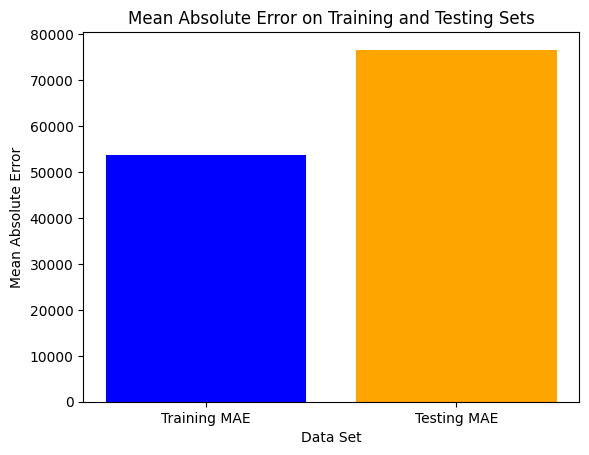

In [76]:
# Evaluasi model menggunakan MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# Plot  MAE
mae_values = [train_mae, test_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### RandomForestRegressor dengan Grid Search


In [6]:
from sklearn.model_selection import GridSearchCV

# Definisikan model
rf_regressor_tuned = RandomForestRegressor(random_state=42)

# Definisikan grid parameter
param_grid = {
    'n_estimators': [90, 100, 110],
    'max_features': [1, 2, 3],
    'max_depth' : [None, 10,20,30],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf' : [1,2,3],
    'bootstrap': [True, False]
}

# Atur Grid Search
grid_search_rf = GridSearchCV(estimator=rf_regressor_tuned, 
                              param_grid=param_grid, 
                              scoring='neg_mean_absolute_error', 
                              cv=5, 
                              verbose=2, 
                              n_jobs=-1)

# Fit Grid Search
grid_search_rf.fit(x_train, y_train)

# Dapatkan parameter terbaik dan skor terbaik
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f'Parameter Terbaik: {best_params_rf}')
print(f'Error Mutlak Rata-rata Terbaik: {-best_score_rf}')


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Parameter Terbaik: {'bootstrap': False, 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 110}
Error Mutlak Rata-rata Terbaik: 135935.7712846572


In [77]:
# menggunakan RandomForestRegressor dengan parameter terbaik
rf_regressor = RandomForestRegressor(
    max_depth=20,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=110,
    bootstrap=False,
    n_jobs=-1
)

# train model
rf_regressor.fit(x_train, y_train)

# prediksi di test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

Training MAE: 77366.74889954449
Test MAE: 128680.488626055


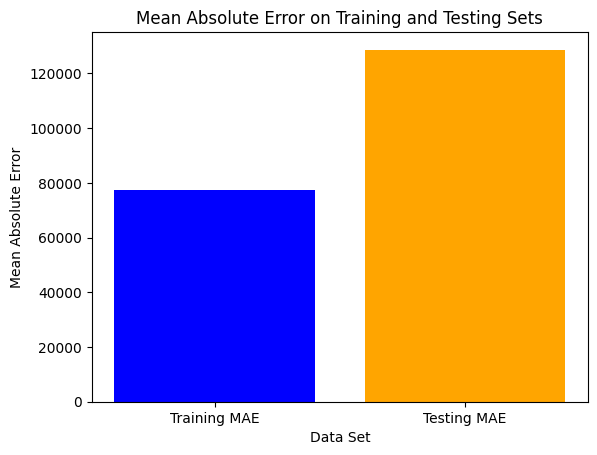

In [78]:
# Evaluate the model using MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# Plot  MAE
mae_values = [train_mae, test_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

#### Cross Validation


In [79]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score

# Define your RandomForestRegressor model
rf_regressor_cv = RandomForestRegressor(
    max_depth=30,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=110,
    bootstrap=False,
    n_jobs=-1
)

# Define the k-fold cross-validation scheme
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring function
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation and get scores
cv_scores = cross_val_score(rf_regressor_cv, x_train, y_train, cv=kf, scoring=scorer)

# Convert negative MAE to positive since we used greater_is_better=False
cv_scores = -cv_scores

# Print the cross-validation scores and their mean
print(f'Cross-Validation MAE Scores: {cv_scores}')
print(f'Mean Cross-Validation MAE: {np.mean(cv_scores)}')

# Fit the model on the entire training data
rf_regressor_cv.fit(x_train, y_train)

# Make predictions on the test data
y_pred_test_cv = rf_regressor_cv.predict(x_test)

# Evaluate the model on the test data
testing_mae_cv = mean_absolute_error(y_test, y_pred_test_cv)
print(f'Mean Absolute Error on Testing: {testing_mae_cv}')


Cross-Validation MAE Scores: [136820.60017459 142242.84736314 138621.54892861 141957.71486872
 140293.96340738]
Mean Cross-Validation MAE: 139987.33494848938
Mean Absolute Error on Testing: 132960.9794671164


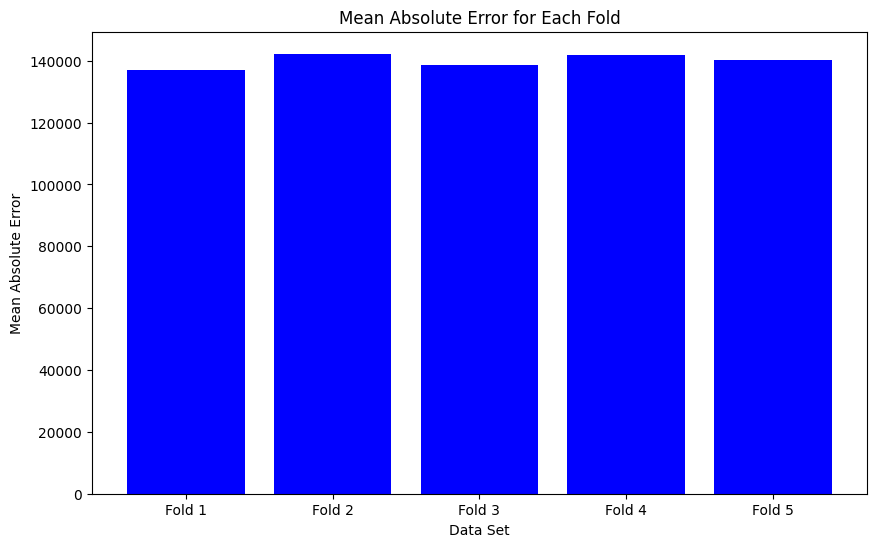

In [80]:
# Plotting the MAE for each fold and the test set
fold_labels = [f'Fold {i+1}' for i in range(len(cv_scores))]

mae_values = list(cv_scores)

plt.figure(figsize=(10, 6))
plt.bar(fold_labels, mae_values, color=['blue']*len(cv_scores))
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error for Each Fold')
plt.show()

### Tampilkan variabel-variabel penting

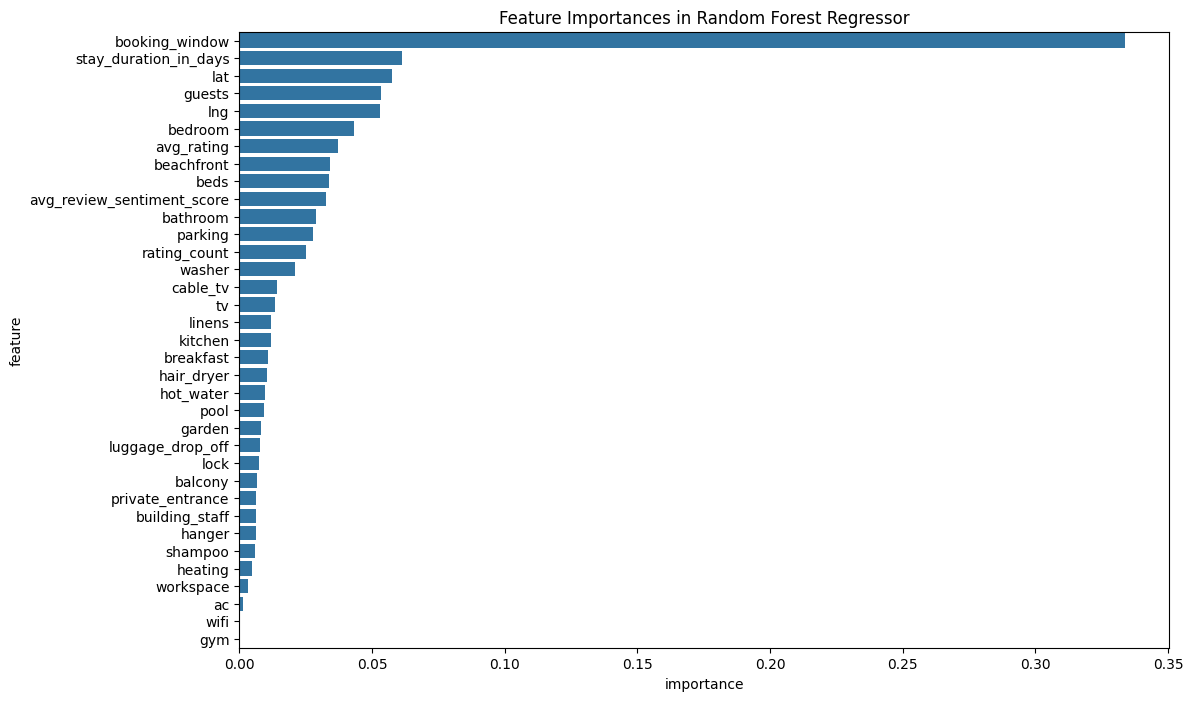

In [81]:
# Get feature importances
feature_importances = rf_regressor.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'feature': xcol.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances in Random Forest Regressor')
plt.show()

### RandomForestRegressor dengan Parameter Terbaik dan 7 Fitur Paling Penting


##### definisi ulang xcol

In [82]:
# mendefinisi kolom yang memprediksi (xcol) dan diprediksi (ycol) 
xcol = df[[
    'booking_window',
    'stay_duration_in_days',
    'lat',
    'beds',
    'bedroom',
    'bathroom',
    'parking',
    'pool',
    'beachfront',
    'lng',
]]

# Split data menjadi set training dan testing
x_train, x_test, y_train, y_test = train_test_split(xcol, ycol, test_size=0.1, random_state=42)

### Lakukan Grid Search Lagi


In [20]:
from sklearn.model_selection import GridSearchCV

# Definisikan model
rf_regressor_tuned = RandomForestRegressor(random_state=42)

# Definisikan grid parameter
param_grid = {
    'n_estimators': [90, 100, 110],
    'max_features': [1, 2, 3],
    'max_depth' : [None, 10,20,30],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf' : [1,2,3],
    'bootstrap': [True, False]
}

# Atur Grid Search
grid_search_rf = GridSearchCV(estimator=rf_regressor_tuned, 
                              param_grid=param_grid, 
                              scoring='neg_mean_absolute_error', 
                              cv=5, 
                              verbose=2, 
                              n_jobs=-1)

# Fit Grid Search
grid_search_rf.fit(x_train, y_train)

# Dapatkan parameter terbaik dan skor terbaik
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f'Parameter Terbaik: {best_params_rf}')
print(f'Error Mutlak Rata-rata Terbaik: {-best_score_rf}')


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Parameter Terbaik: {'bootstrap': False, 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Error Mutlak Rata-rata Terbaik: 59355.82087372364


##### buat ulang RandomForestRegressor

In [83]:
# menggunakan RandomForestRegressor dengan parameter terbaik
rf_regressor = RandomForestRegressor(
    max_depth=None,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    bootstrap=False,
    n_jobs=-1
)

# train model
rf_regressor.fit(x_train, y_train)

# prediksi di test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

Training MAE: 49558.016725684894
Test MAE: 56512.93510763791


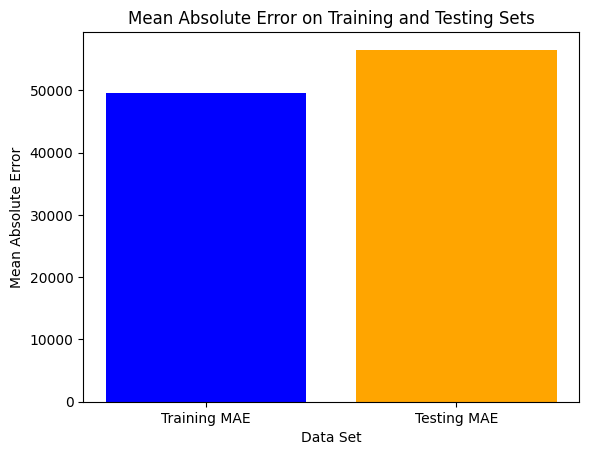

In [84]:
# Evaluate the model using MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# Plot  MAE
mae_values = [train_mae, test_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

#### Cross Validation


In [85]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score

# Define your RandomForestRegressor model
rf_regressor_cv = RandomForestRegressor(
    max_depth=30,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=110,
    bootstrap=False,
    n_jobs=-1
)

# Define the k-fold cross-validation scheme
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring function
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation and get scores
cv_scores = cross_val_score(rf_regressor_cv, x_train, y_train, cv=kf, scoring=scorer)

# Convert negative MAE to positive since we used greater_is_better=False
cv_scores = -cv_scores

# Print the cross-validation scores and their mean
print(f'Cross-Validation MAE Scores: {cv_scores}')
print(f'Mean Cross-Validation MAE: {np.mean(cv_scores)}')

# Fit the model on the entire training data
rf_regressor_cv.fit(x_train, y_train)

# Make predictions on the test data
y_pred_test_cv = rf_regressor_cv.predict(x_test)

# Evaluate the model on the test data
testing_mae_cv = mean_absolute_error(y_test, y_pred_test_cv)
print(f'Mean Absolute Error on Testing: {testing_mae_cv}')


Cross-Validation MAE Scores: [60730.71476742 61651.58193881 57679.00459672 57959.8096803
 59497.23767575]
Mean Cross-Validation MAE: 59503.66973179963
Mean Absolute Error on Testing: 56365.88164842295


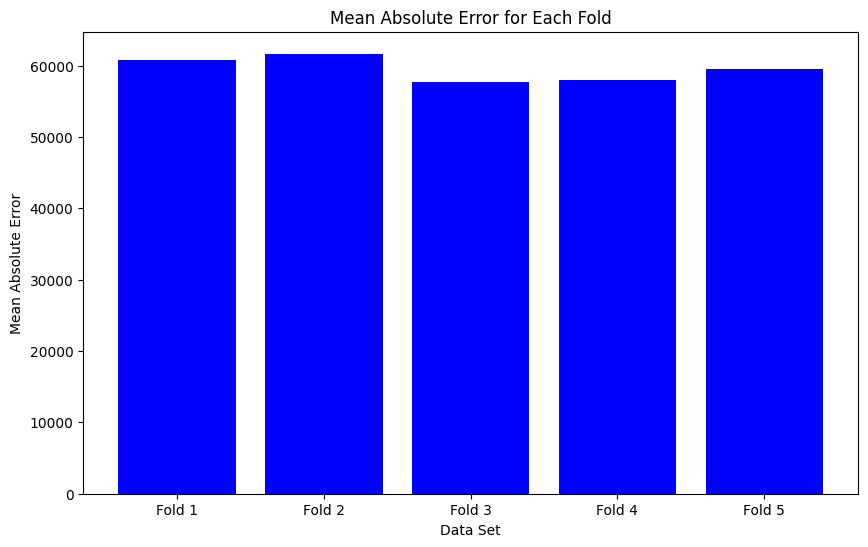

In [86]:
# Plotting the MAE for each fold and the test set
fold_labels = [f'Fold {i+1}' for i in range(len(cv_scores))]

mae_values = list(cv_scores)

plt.figure(figsize=(10, 6))
plt.bar(fold_labels, mae_values, color=['blue']*len(cv_scores))
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error for Each Fold')
plt.show()

### Convert Model ke PKL

In [87]:
import joblib

# Save the trained model to a file
joblib.dump(rf_regressor, 'random_forest_model.pkl')

['random_forest_model.pkl']

### Load dan tes model

In [88]:
# Load the trained Random Forest model
randomforest_model = joblib.load('random_forest_model.pkl')

# Use Random Forest model to make predictions
randomforest_predictions_test = randomforest_model.predict(x_test)

# Now you can use these predictions
print("Predictions:", randomforest_predictions_test[:10])
print("Actual Prices:", y_test[:10])

Predictions: [ 565889.04698925  522607.25        411220.22157143 1910377.08
  466652.53125     372592.75        480062.          414893.16825396
  338421.81728574  975194.        ]
Actual Prices: 3003     3.895795e+05
15000    5.226072e+05
35864    3.900705e+05
46528    1.910377e+06
14579    5.000842e+05
13480    3.725928e+05
26793    4.800620e+05
53618    2.500347e+05
50848    3.825765e+05
52849    9.751940e+05
Name: average_daily_rate, dtype: float64


## Data Pipeline untuk Prediksi

In [89]:
# mendefinisi kolom yang memprediksi (xcol) dan diprediksi (ycol) 
predicted_column = [
    'property_name', 
    'room_id',
    'booking_window',
    'stay_duration_in_days',
    'lat',
    'beds',
    'bedroom',
    'bathroom',
    'parking',
    'pool',
    'beachfront',
    'lng',
    'average_daily_rate',
]

X_predicted = df[predicted_column]

In [90]:
X_predicted.head()

,property_name,room_id,booking_window,stay_duration_in_days,lat,beds,bedroom,bathroom,parking,pool,beachfront,lng,average_daily_rate
0,Bingin Ombak,431874,81,4,-8.805646,1,1,1,0,0,1,115.113378,1.477799e+06
1,Bingin Ombak,431875,81,4,-8.805646,1,1,1,0,0,1,115.113378,1.477799e+06
2,Bingin Ombak,396658,81,4,-8.805646,1,1,1,0,0,1,115.113378,1.477799e+06
3,Bingin Ombak,396427,81,4,-8.805646,1,1,2,0,0,1,115.113378,1.477799e+06
4,Bingin Ombak,396427,81,4,-8.805646,1,1,2,0,0,1,115.113378,1.477799e+06


In [91]:
X_predicted.shape

(56683, 13)

### Drop Data Duplikat

In [92]:
distinct_data = X_predicted.drop_duplicates(subset=['property_name', 'room_id'])

In [93]:
distinct_data.shape

(178, 13)

### Save Distinct Data

In [94]:
distinct_data.to_csv('random_forest_distinct_data.csv', index=False)

### Tes dengan Data Baru

In [95]:
import pandas as pd
from datetime import date
import joblib


def booking_window(today, check_in):
    return (check_in - today).days

def stay_duration(check_in, check_out):
    return (check_out - check_in).days

def predict(predicted_df, property_name, room_id, check_in, check_out):
    # Select property name and room_id
    filtered_df = predicted_df[(predicted_df['property_name'] == property_name) & 
                              (predicted_df['room_id'] == room_id)].copy()
    
    if filtered_df.empty:
        raise ValueError("No matching property_name and room_id found in the data")
    
    # Save the current price
    current_price = filtered_df['average_daily_rate'].values
    
    # Drop unnecessary columns
    filtered_df.drop(columns=['property_name', 'room_id', 'average_daily_rate'], inplace=True)
    
    # Feature engineering booking window
    today = date.today()
    booking_window_days = booking_window(today, check_in)
    
    # Feature engineering stay duration
    stay_duration_days = stay_duration(check_in, check_out)
    
    # Replace values in columns
    filtered_df['stay_duration_in_days'] = stay_duration_days
    filtered_df['booking_window'] = booking_window_days
    
    print("Booking window (days):", booking_window_days)
    print("Stay duration (days):", stay_duration_days)
    
    # Predict
    random_forest_model = joblib.load('random_forest_model.pkl')
    xgboost_predictions_test = random_forest_model.predict(filtered_df)
    
    return xgboost_predictions_test, current_price

def format_currency(value):
    value_str = f"{value:,.2f}"
    value_str = value_str.replace(',', 'X').replace('.', ',').replace('X', '.')
    return f"Rp {value_str}"

# Example usage
check_in = date(2024, 12, 1)
check_out = date(2024, 12, 30)

prediction, current_price = predict(distinct_data, 'Amazon Guesthouse', 397693, check_in, check_out)
formatted_current_price = format_currency(current_price[0])
formatted_prediction = format_currency(prediction[0])

print("Current Price:", formatted_current_price)
print("Prediction:", formatted_prediction)

Booking window (days): 172
Stay duration (days): 29
Current Price: Rp 446.768,58
Prediction: Rp 467.196,25
